# Importing libraries

In [102]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

## LSTM many to many with N Sequence to output
## On real data from collector 110

In [9]:
data = pd.read_csv("C:/Users/dmamed01/projects/rul_lstm/machine_110.csv")




In [10]:
data

,Unnamed: 0,END_TIMESTAMP,DURATION_MACHINE_ON,OP_HRS,AVG_READING
0,0,2021-09-14 20:53:33.590000+00:00,2830.0,0.786111,411.297410
1,1,2021-09-14 21:53:34.530000+00:00,3601.0,1.786389,415.708651
2,2,2021-09-14 22:53:32.220000+00:00,3598.0,2.785833,424.786748
3,3,2021-09-14 23:53:35.320000+00:00,3603.0,3.786667,430.625419
4,4,2021-09-15 00:53:31.300000+00:00,3596.0,4.785556,441.260713
...,...,...,...,...,...
22983,22983,2025-01-01 19:47:08.400000+00:00,7174.0,22983.836944,552.925420
22984,22984,2025-01-01 20:47:09.400000+00:00,7188.0,22984.835278,553.274728
22985,22985,2025-01-01 21:47:05.130000+00:00,7178.0,22985.832222,555.197066
22986,22986,2025-01-01 22:47:06.900000+00:00,7186.0,22986.830278,551.009203


In [100]:
# slice data from 1000 to 2000
real_curve_one = data[1698:3944]
real_curve_two = data[3945:6386]
real_curve_three = data[6388:10328]


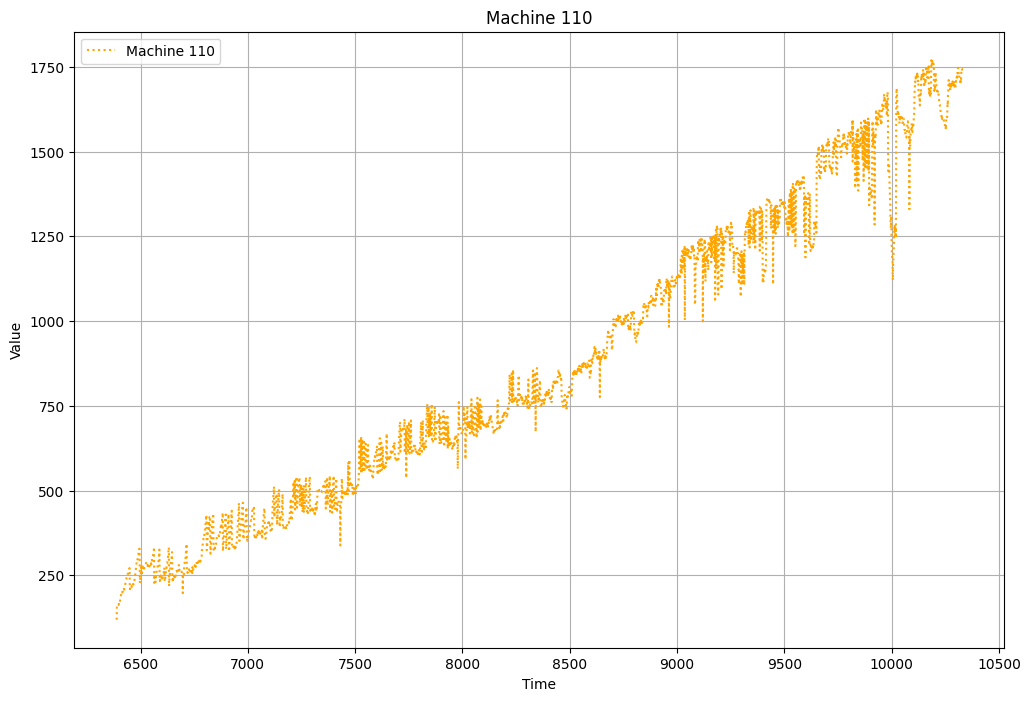

In [101]:
# Plot sample curves
plt.figure(figsize=(12, 8))

plt.plot(real_curve_three['OP_HRS'], real_curve_three['AVG_READING'], label="Machine 110", color="orange", linestyle=":")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Machine 110")
plt.legend()
plt.grid(True)
plt.show()

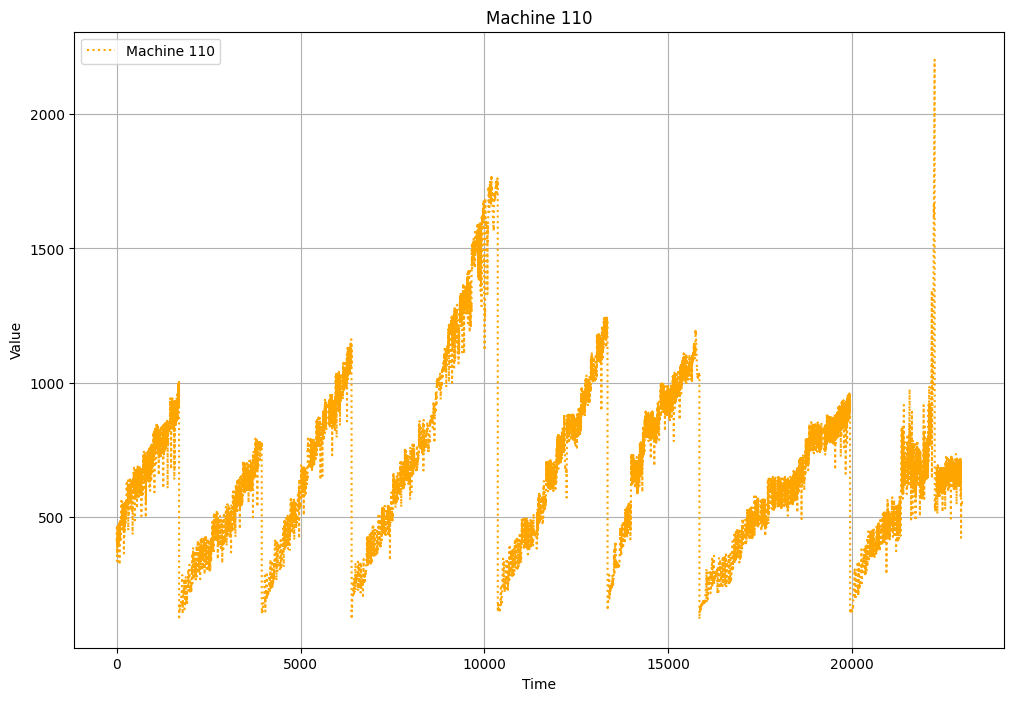

In [11]:
# Plot sample curves
plt.figure(figsize=(12, 8))

plt.plot(data['OP_HRS'], data['AVG_READING'], label="Machine 110", color="orange", linestyle=":")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Machine 110")
plt.legend()
plt.grid(True)
plt.show()

# Data generation

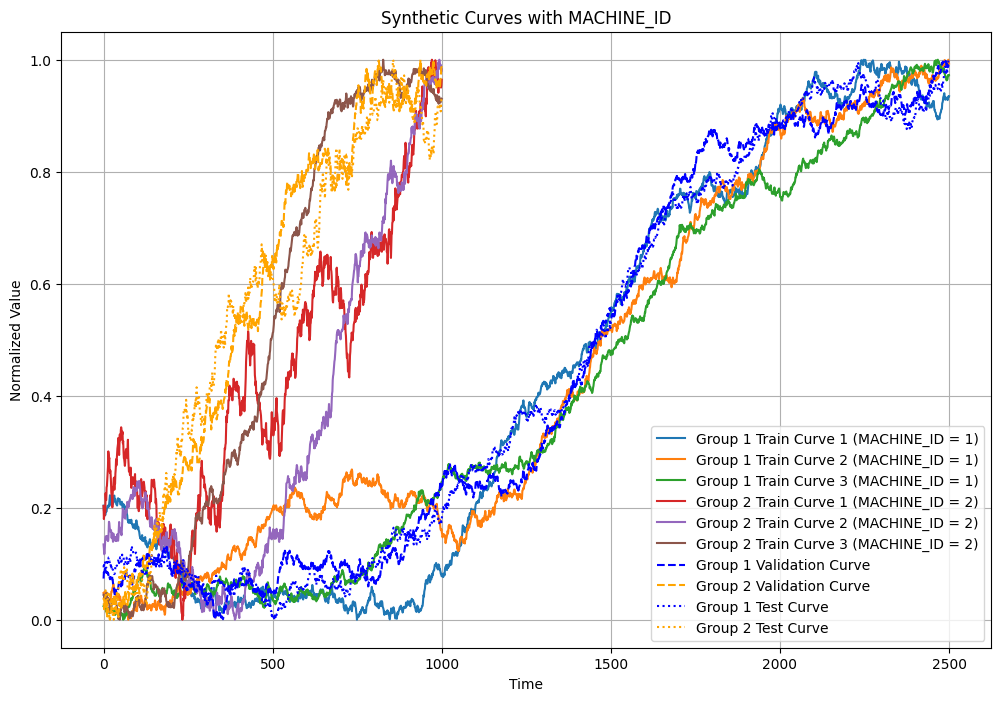

In [13]:


# Logistic function
def logistic_curve(x, L, k, x0, b):
    """Generate a logistic curve."""
    return L / (1 + np.exp(-k * (x - x0))) + b

# Add noise to data
def add_noise(data, noise_level=0.05):
    """Add random noise to the curve."""
    noise = np.random.normal(0, noise_level, len(data))
    cumulative_noise = np.cumsum(np.random.normal(0, noise_level * 10, len(data)))
    return data + noise + cumulative_noise

# Generate curves
def generate_curves(num_curves, t, param_ranges, machine_id, noise_level=0.05):
    """Generate multiple logistic curves with noise and machine ID."""
    curves = []
    machine_id_encoded = np.array([1, 0]) if machine_id == 1 else np.array([0, 1])
    for _ in range(num_curves):
        L = np.random.uniform(*param_ranges['L'])
        k = np.random.uniform(*param_ranges['k'])
        x0 = np.random.uniform(*param_ranges['x0'])
        b = np.random.uniform(*param_ranges['b'])
        curve = logistic_curve(t, L, k, x0, b)
        curve = add_noise(curve, noise_level)
        curve_with_id = np.column_stack((curve, np.tile(machine_id_encoded, (len(t), 1))))  # Add MACHINE_ID
        curves.append(curve_with_id)
    return curves

# Time points
t_group_1 = np.linspace(0, 2500, 2500)
t_group_2 = np.linspace(0, 1000, 1000)

# Parameter ranges for each group
param_ranges_group_1 = {"L": [900, 1300], "k": [0.002, 0.006], "x0": [1200, 1700], "b": [0.01, 0.1]}
param_ranges_group_2 = {"L": [500, 900], "k": [0.003, 0.01], "x0": [400, 800], "b": [0.05, 0.2]}

# Generate training, validation, and test curves
train_curves_group_1 = generate_curves(5, t_group_1, param_ranges_group_1, machine_id=1, noise_level=0.5)
train_curves_group_2 = generate_curves(5, t_group_2, param_ranges_group_2, machine_id=2, noise_level=0.5)

val_curve_group_1 = generate_curves(1, t_group_1, param_ranges_group_1, machine_id=1, noise_level=0.5)[0]
val_curve_group_2 = generate_curves(1, t_group_2, param_ranges_group_2, machine_id=2, noise_level=0.5)[0]

test_curve_group_1 = generate_curves(1, t_group_1, param_ranges_group_1, machine_id=1, noise_level=0.5)[0]
test_curve_group_2 = generate_curves(1, t_group_2, param_ranges_group_2, machine_id=2, noise_level=0.5)[0]

# Normalize curves
scaler = MinMaxScaler()

def normalize_curves(curves):
    normalized_curves = []
    for curve in curves:
        scaled_curve = scaler.fit_transform(curve[:, 0].reshape(-1, 1)).flatten()  # Normalize the logistic values
        combined = np.column_stack((scaled_curve, curve[:, 1:]))  # Combine with MACHINE_ID
        normalized_curves.append(combined)
    return normalized_curves

train_curves_group_1 = normalize_curves(train_curves_group_1)
train_curves_group_2 = normalize_curves(train_curves_group_2)
val_curve_group_1 = normalize_curves([val_curve_group_1])[0]
val_curve_group_2 = normalize_curves([val_curve_group_2])[0]
test_curve_group_1 = normalize_curves([test_curve_group_1])[0]
test_curve_group_2 = normalize_curves([test_curve_group_2])[0]

# Plot sample curves
plt.figure(figsize=(12, 8))
for i, curve in enumerate(train_curves_group_1[:3]):
    plt.plot(t_group_1, curve[:, 0], label=f"Group 1 Train Curve {i+1} (MACHINE_ID = 1)")
for i, curve in enumerate(train_curves_group_2[:3]):
    plt.plot(t_group_2, curve[:, 0], label=f"Group 2 Train Curve {i+1} (MACHINE_ID = 2)")
plt.plot(t_group_1, val_curve_group_1[:, 0], label="Group 1 Validation Curve", color="blue", linestyle="--")
plt.plot(t_group_2, val_curve_group_2[:, 0], label="Group 2 Validation Curve", color="orange", linestyle="--")
plt.plot(t_group_1, test_curve_group_1[:, 0], label="Group 1 Test Curve", color="blue", linestyle=":")
plt.plot(t_group_2, test_curve_group_2[:, 0], label="Group 2 Test Curve", color="orange", linestyle=":")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.title("Synthetic Curves with MACHINE_ID")
plt.legend()
plt.grid(True)
plt.show()


# Data preparation pytorch *Dataset* and *DataLoader*

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesManyToManyDataset(Dataset):
    def __init__(self, curves, seq_len):
        """
        Parameters:
        - curves: List of numpy arrays, each with shape (time_steps, features).
        - seq_len: Length of the input and target sequences.
        """
        self.curves = [torch.tensor(curve, dtype=torch.float32) for curve in curves]
        self.seq_len = seq_len

        # Precompute lengths to handle indexing across multiple curves
        self.cumulative_lengths = torch.cumsum(
            torch.tensor([max(0, len(curve) - 2 * seq_len) for curve in self.curves]),
            dim=0
        )

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, idx):
        """
        Returns:
        - x: Input sequence (seq_len, features).
        - y: Target sequence (seq_len, features).
        """
        # Determine which curve this index belongs to
        curve_idx = torch.searchsorted(self.cumulative_lengths, idx, right=True)
        curve_start_idx = 0 if curve_idx == 0 else self.cumulative_lengths[curve_idx - 1].item()
        local_idx = idx - curve_start_idx

        curve = self.curves[curve_idx]
        x = curve[local_idx : local_idx + self.seq_len, :]  # Input sequence (value, machine_id cols)
        y = curve[local_idx + self.seq_len : local_idx + 2 * self.seq_len, 0].unsqueeze(1)  # Target sequence value col
        return x, y


In [31]:
val_curve_group_1

array([[0.07349699, 1.        , 0.        ],
       [0.08489409, 1.        , 0.        ],
       [0.08142175, 1.        , 0.        ],
       ...,
       [0.98984729, 1.        , 0.        ],
       [0.98945434, 1.        , 0.        ],
       [0.99090059, 1.        , 0.        ]], shape=(2500, 3))

In [79]:
# Sequence length
seq_len = 50

# Create datasets
train_curves = train_curves_group_1 + train_curves_group_2


train_dataset = TimeSeriesManyToManyDataset(train_curves, seq_len)
val_dataset_one = TimeSeriesManyToManyDataset([val_curve_group_1], seq_len)
test_dataset_one = TimeSeriesManyToManyDataset([test_curve_group_1], seq_len)
val_dataset_two = TimeSeriesManyToManyDataset([val_curve_group_2], seq_len)
test_dataset_two = TimeSeriesManyToManyDataset([test_curve_group_2], seq_len)

# DataLoader parameters
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_one, batch_size=batch_size, shuffle=False)
val_loader_2 = DataLoader(val_dataset_two, batch_size=batch_size, shuffle=False)
test_loader_1 = DataLoader(test_dataset_one, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_two, batch_size=batch_size, shuffle=False)

# Check dataset lengths
print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset 1: {len(val_dataset_one)} samples")
print(f"Validation Dataset 2: {len(val_dataset_two)} samples")
print(f"Test Dataset 1: {len(test_dataset_one)} samples")
print(f"Test Dataset 2: {len(test_dataset_two)} samples")


Training Dataset: 16500 samples
Validation Dataset 1: 2400 samples
Validation Dataset 2: 900 samples
Test Dataset 1: 2400 samples
Test Dataset 2: 900 samples


# Model definition

In [103]:
import torch.nn as nn

class ManyToManyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(ManyToManyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM produces outputs for each time step
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_dim]
        output = self.fc(lstm_out)  # Map to output_dim for each time step
        return output  # Shape: [batch_size, seq_len, output_dim]


In [81]:
# Hyperparameters
input_dim = 3
hidden_dim = 50
output_dim = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.001


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ManyToManyLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with validation

In [82]:

num_epochs = 25
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_loader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        # torch.Size([32, 50, 1])
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_loader_1, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            v_predictions = model(x_batch_val)
            val_predictions.extend(v_predictions.cpu().numpy())
            loss = criterion(v_predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_loader_1)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


V Eph 1/25: 100%|██████████| 75/75 [00:00<00:00, 484.45it/s]


Epoch 1/25, T Loss: 0.019453731347, V Loss: 0.003322386576


V Eph 2/25: 100%|██████████| 75/75 [00:00<00:00, 474.25it/s]


Epoch 2/25, T Loss: 0.004010499305, V Loss: 0.002039762097


V Eph 3/25: 100%|██████████| 75/75 [00:00<00:00, 457.26it/s]


Epoch 3/25, T Loss: 0.003087363054, V Loss: 0.000912135208


V Eph 4/25: 100%|██████████| 75/75 [00:00<00:00, 473.72it/s]


Epoch 4/25, T Loss: 0.002805637080, V Loss: 0.000818353402


V Eph 5/25: 100%|██████████| 75/75 [00:00<00:00, 478.93it/s]


Epoch 5/25, T Loss: 0.002716717442, V Loss: 0.001087335242


V Eph 6/25: 100%|██████████| 75/75 [00:00<00:00, 495.47it/s]


Epoch 6/25, T Loss: 0.002678095792, V Loss: 0.000851284231


V Eph 7/25: 100%|██████████| 75/75 [00:00<00:00, 470.15it/s]


Epoch 7/25, T Loss: 0.002643192358, V Loss: 0.000780437872


V Eph 8/25: 100%|██████████| 75/75 [00:00<00:00, 503.15it/s]


Epoch 8/25, T Loss: 0.002602191891, V Loss: 0.000884398119


V Eph 9/25: 100%|██████████| 75/75 [00:00<00:00, 457.07it/s]


Epoch 9/25, T Loss: 0.002630612692, V Loss: 0.000957270964


V Eph 10/25: 100%|██████████| 75/75 [00:00<00:00, 464.79it/s]


Epoch 10/25, T Loss: 0.002583232097, V Loss: 0.000773590743


V Eph 11/25: 100%|██████████| 75/75 [00:00<00:00, 480.36it/s]


Epoch 11/25, T Loss: 0.002573488532, V Loss: 0.000825584305


V Eph 12/25: 100%|██████████| 75/75 [00:00<00:00, 480.06it/s]


Epoch 12/25, T Loss: 0.002590555327, V Loss: 0.000801235705


V Eph 13/25: 100%|██████████| 75/75 [00:00<00:00, 468.88it/s]


Epoch 13/25, T Loss: 0.002559802558, V Loss: 0.001006843541


V Eph 14/25: 100%|██████████| 75/75 [00:00<00:00, 499.71it/s]


Epoch 14/25, T Loss: 0.002563016174, V Loss: 0.000821484456


V Eph 15/25: 100%|██████████| 75/75 [00:00<00:00, 445.75it/s]


Epoch 15/25, T Loss: 0.002531453703, V Loss: 0.000852243979


V Eph 16/25: 100%|██████████| 75/75 [00:00<00:00, 483.01it/s]


Epoch 16/25, T Loss: 0.002553988000, V Loss: 0.000922311959


V Eph 17/25: 100%|██████████| 75/75 [00:00<00:00, 472.11it/s]


Epoch 17/25, T Loss: 0.002546624311, V Loss: 0.000804726769


V Eph 18/25: 100%|██████████| 75/75 [00:00<00:00, 496.44it/s]


Epoch 18/25, T Loss: 0.002513849443, V Loss: 0.000785158467


V Eph 19/25: 100%|██████████| 75/75 [00:00<00:00, 498.06it/s]


Epoch 19/25, T Loss: 0.002537407886, V Loss: 0.000954228727


V Eph 20/25: 100%|██████████| 75/75 [00:00<00:00, 505.30it/s]


Epoch 20/25, T Loss: 0.002532458299, V Loss: 0.000786637189


V Eph 21/25: 100%|██████████| 75/75 [00:00<00:00, 476.92it/s]


Epoch 21/25, T Loss: 0.002525659310, V Loss: 0.000773474639


V Eph 22/25: 100%|██████████| 75/75 [00:00<00:00, 503.25it/s]


Epoch 22/25, T Loss: 0.002535120416, V Loss: 0.000868938089


V Eph 23/25: 100%|██████████| 75/75 [00:00<00:00, 410.01it/s]


Epoch 23/25, T Loss: 0.002515336147, V Loss: 0.000881113268


V Eph 24/25: 100%|██████████| 75/75 [00:00<00:00, 472.19it/s]


Epoch 24/25, T Loss: 0.002516388114, V Loss: 0.001022087414


V Eph 25/25: 100%|██████████| 75/75 [00:00<00:00, 449.13it/s]

Epoch 25/25, T Loss: 0.002527638641, V Loss: 0.000785377119


In [37]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Log losses
writer.add_scalar("Loss/Train", train_loss, epoch)
writer.add_scalar("Loss/Validation", val_loss, epoch)


# Visualization


In [83]:
def get_sequence_from_curve(curve, start_idx, seq_len):
    """
    Extract a sequence of a specified length from the curve starting at a given index.

    Parameters:
    - curve: The complete time series (1D numpy array or list).
    - start_idx: The starting index for the sequence.
    - seq_len: The length of the sequence to extract.

    Returns:
    - The extracted sequence as a numpy array.
    """
    end_idx = start_idx + seq_len
    if end_idx > len(curve):
        raise ValueError(f"End index {end_idx} exceeds curve length {len(curve)}.")
    return curve[start_idx:end_idx]


In [86]:
# Long horizon prediction using Many-to-Many model
long_horizon = 250  # Number of steps to predict
start_idx = 0  # Start index for the input sequence
seq_len = 50  # Length of the input sequence

# Get input sequence
x_input = get_sequence_from_curve(test_curve_group_1, start_idx, seq_len)  # Fetch the initial sequence
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, features]

print(f"Initial input shape: {x_input_tensor.shape}")

# Initialize list to store all predictions
all_predictions = []

# Auto-regressive prediction loop
model.eval()
with torch.no_grad():
    for _ in range(long_horizon // seq_len):
        # Predict the next sequence
        predictions = model(x_input_tensor).squeeze(0).cpu().numpy()  # Output shape: [seq_len, output_dim]
        all_predictions.append(predictions)

        print("predictions.shape", predictions.shape)

        # Use the predicted sequence as the next input
        x_input_tensor = torch.tensor(predictions, dtype=torch.float32).unsqueeze(0).to(device)
        print("x_input_tensor.shape", x_input_tensor.shape)

# Combine all predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)[:, 0]  # Only select the logistic value (first feature)

# Smooth predictions
smoothed_predictions = savgol_filter(all_predictions[:long_horizon], window_length=11, polyorder=2)

# Visualization
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + len(all_predictions))

plt.figure(figsize=(12, 6))
# Original test curve
plt.plot(np.arange(len(test_curve_group_1)), test_curve_group_1[:, 0], label="Test Curve (Logistic Value)", color="gray", alpha=0.5)
# Input sequence
plt.plot(np.arange(start_idx, start_idx + seq_len), x_input[:, 0], label="Input Sequence (Blue)", color="blue", linewidth=2)
# Smoothed predictions
plt.plot(prediction_indices, smoothed_predictions, label="Smoothed Predicted Sequence (Red)", color="red", linewidth=2)

plt.title(f"Many-to-Many Long Horizon Prediction ({long_horizon} Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


Initial input shape: torch.Size([1, 50, 3])
predictions.shape (50, 1)
x_input_tensor.shape torch.Size([1, 50, 1])


RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 1

Initial input shape: torch.Size([1, 50, 3])


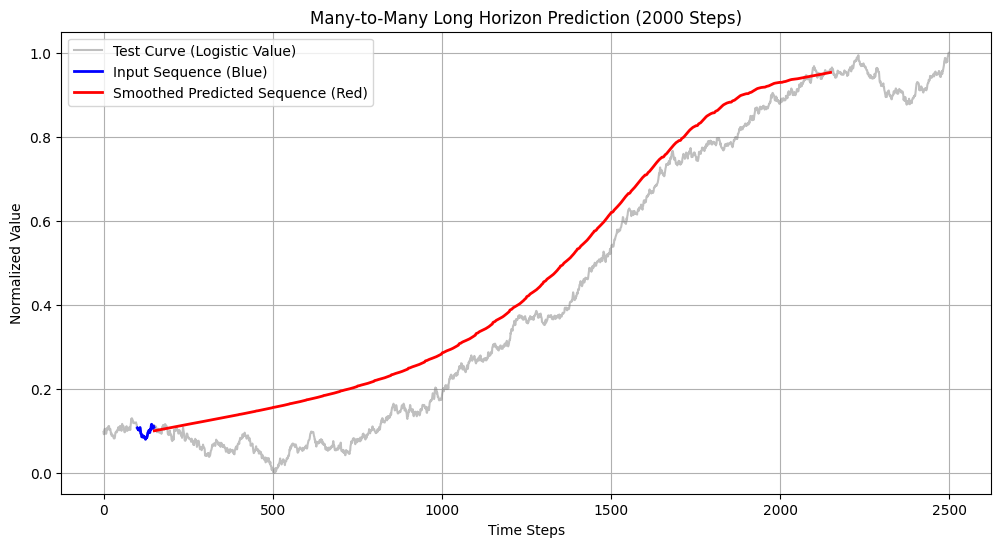

In [107]:
# Long horizon prediction using Many-to-Many model
long_horizon = 2000  # Number of steps to predict
start_idx = 100  # Start index for the input sequence
seq_len = 50  # Length of the input sequence

# Get input sequence
x_input = get_sequence_from_curve(test_curve_group_1, start_idx, seq_len)  # Fetch the initial sequence
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, features]

print(f"Initial input shape: {x_input_tensor.shape}")

# Initialize list to store all predictions
all_predictions = []

# Auto-regressive prediction loop
model.eval()
with torch.no_grad():
    for _ in range(long_horizon // seq_len):
        # Predict the next sequence
        predictions = model(x_input_tensor).squeeze(0).cpu().numpy()  # Output shape: [seq_len, output_dim]
        all_predictions.append(predictions)

        # Add col 1, 0 to predictions
        predictions = np.column_stack((predictions, np.ones(len(predictions)), np.zeros(len(predictions))))
        # Use the predicted sequence as the next input
        x_input_tensor = torch.tensor(predictions, dtype=torch.float32).unsqueeze(0).to(device)

# Combine all predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)[:, 0]  # Only select the logistic value (first feature)

# Smooth predictions
smoothed_predictions = savgol_filter(all_predictions[:long_horizon], window_length=201, polyorder=1)

# Visualization
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + len(all_predictions))

plt.figure(figsize=(12, 6))
# Original test curve
plt.plot(np.arange(len(test_curve_group_1)), test_curve_group_1[:, 0], label="Test Curve (Logistic Value)", color="gray", alpha=0.5)
# Input sequence
plt.plot(np.arange(start_idx, start_idx + seq_len), x_input[:, 0], label="Input Sequence (Blue)", color="blue", linewidth=2)
# Smoothed predictions
plt.plot(prediction_indices, smoothed_predictions, label="Smoothed Predicted Sequence (Red)", color="red", linewidth=2)

plt.title(f"Many-to-Many Long Horizon Prediction ({long_horizon} Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


Initial input shape: torch.Size([1, 50, 3])


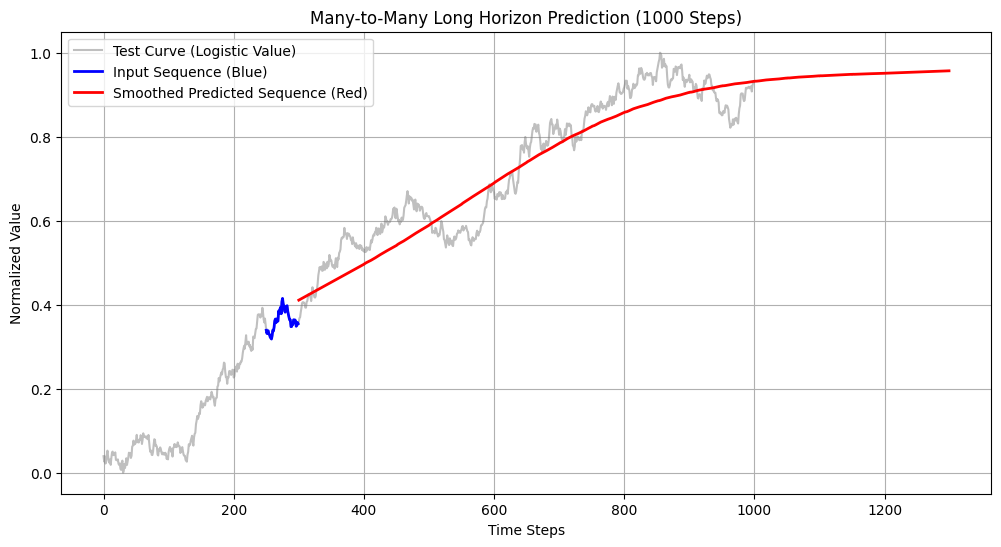

In [108]:
# Long horizon prediction using Many-to-Many model
long_horizon = 1000  # Number of steps to predict
start_idx = 250  # Start index for the input sequence
seq_len = 50  # Length of the input sequence

# Get input sequence
x_input = get_sequence_from_curve(test_curve_group_2, start_idx, seq_len)  # Fetch the initial sequence
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, features]

print(f"Initial input shape: {x_input_tensor.shape}")

# Initialize list to store all predictions
all_predictions = []

# Auto-regressive prediction loop
model.eval()
with torch.no_grad():
    for _ in range(long_horizon // seq_len):
        # Predict the next sequence
        predictions = model(x_input_tensor).squeeze(0).cpu().numpy()  # Output shape: [seq_len, output_dim]
        all_predictions.append(predictions)

        # Add col 1, 0 to predictions
        predictions = np.column_stack((predictions, np.ones(len(predictions)), np.zeros(len(predictions))))
        # Use the predicted sequence as the next input
        x_input_tensor = torch.tensor(predictions, dtype=torch.float32).unsqueeze(0).to(device)

# Combine all predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)[:, 0]  # Only select the logistic value (first feature)

# Smooth predictions
smoothed_predictions = savgol_filter(all_predictions[:long_horizon], window_length=201, polyorder=1)

# Visualization
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + len(all_predictions))

plt.figure(figsize=(12, 6))
# Original test curve
plt.plot(np.arange(len(test_curve_group_2)), test_curve_group_2[:, 0], label="Test Curve (Logistic Value)", color="gray", alpha=0.5)
# Input sequence
plt.plot(np.arange(start_idx, start_idx + seq_len), x_input[:, 0], label="Input Sequence (Blue)", color="blue", linewidth=2)
# Smoothed predictions
plt.plot(prediction_indices, smoothed_predictions, label="Smoothed Predicted Sequence (Red)", color="red", linewidth=2)

plt.title(f"Many-to-Many Long Horizon Prediction ({long_horizon} Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()
